In [1]:
import os
import sys
# Allow this notebook to import local libraries 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from topic_modelling.preprocessor_all import load_data
from topic_modelling.pipelines import basic_pipeline, spacy_pipeline
from topic_modelling.preprocessor_all import load_data
from topic_modelling.models import BasicModel, HierarchicalModel, EnsembleModel, NMFModel

import warnings
warnings.filterwarnings('ignore')

# Table of contents
* [1. Load and preprocess data](#1)
* [2. Date-preprocessing](#2)
    * [2.1 LDA Basic Mode](#2.1)
        * [2.1.1 Hyper-parameter Tuning](#2.1.1)
        * [2.1.2 Find best number of topics](#2.1.2)
        * [2.1.3 Grid Search](#2.1.3)
    * [2.2 NMF](#2.2)
    * [2.3 Ensemble](#2.3)
    

## 1. Load and preprocess data <a class="anchor" id="1"></a>

In [3]:
df = load_data()
df = spacy_pipeline.apply(df, column='cleanBody')

Func:load_data took: 0.49 seconds
Func:reset_index took: 0.01 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:demoji_preprocessor took: 19.72 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:tweet_preprocessor took: 1.20 seconds
:: Spacy preprocessor -> cleaning, this might take 1-2 minutes....


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:spacy_preprocessor took: 56.73 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:predefined_denoiser took: 0.09 seconds
Func:drop_empty took: 0.03 seconds
Func:reset_index took: 0.00 seconds


Pandas Apply:   0%|          | 0/42360 [00:00<?, ?it/s]

Func:tokenizer_transformer took: 0.37 seconds


Pandas Apply:   0%|          | 0/42360 [00:00<?, ?it/s]

Func:ngrammer_2_3 took: 0.58 seconds


# 2. Model Selection<a class="anchor" id="2"></a>

## 2.1 LDA Basic Model<a class="anchor" id="2.1"></a>

In [26]:
basic_model = BasicModel()
basic_model.fit(df,'cleanBody')
basic_model.train(num_topics=6, 
                  passes=1,
                  chunksize=100,
                  eval_every=10,
                  alpha = 0.9,
                  decay=0.3
                 )

print(basic_model.get_coherance())

:: Size of id2word: 25387
Func:createid2word_dictionary took: 0.23 seconds
Func:filter_extremes took: 0.02 seconds
Func:create_bow_coprpus took: 0.10 seconds
----> Training BasicModel <----
Func:train took: 3.74 seconds

Coherence Score:  0.5748280628352505
Func:get_coherance took: 2.60 seconds
0.5748280628352505


In [27]:
print(basic_model.get_topics())

------ Topic 0 ------
palm_springs usa holiday love rent bed_breakfasts san_diego guest_room mid_century modern_houses

------ Topic 1 ------
holiday palm_springs owl_house bed_breakfasts san_diego rent_hightown guest_room condo love mid_century

------ Topic 2 ------
love palm_springs holiday usa rent rt modern_houses san_diego guest_room mid_century

------ Topic 3 ------
san_diego vacation_rental usa mission_beach condo palm_springs holiday rent_hightown owl_house guest_room

------ Topic 4 ------
palm_springs rent modern_houses holiday mid_century love san_diego usa christmas condo

------ Topic 5 ------
palm_springs holiday bed_breakfasts mid_century guest_room owl_house rent_hightown rent modern_houses love

None


/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### 2.1.1 Hyper-parameter Tuning<a class="anchor" id="2.1.1"></a>

### 2.1.2 Find best number of topics<a class="anchor" id="2.1.2"></a>

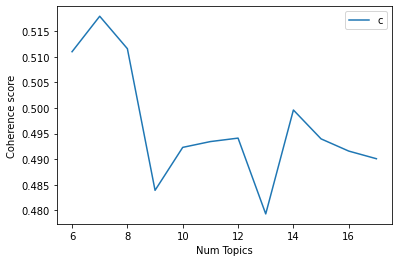

In [5]:
model_list, coherence_values = basic_model.compute_coherence_values(start=6, limit=18, step=1, plot=True)

In [6]:
for m,c in (zip(model_list, coherence_values)):
    print(f"Topics:{m.num_topics},Coherence score:{c}")

Topics:6,Coherence score:0.5110152155475262
Topics:7,Coherence score:0.51795216987792
Topics:8,Coherence score:0.5116074421550758
Topics:9,Coherence score:0.48391288257384246
Topics:10,Coherence score:0.49231141130199096
Topics:11,Coherence score:0.4934458170164726
Topics:12,Coherence score:0.49412231094784564
Topics:13,Coherence score:0.47930072947792984
Topics:14,Coherence score:0.499621466283475
Topics:15,Coherence score:0.49397368986739093
Topics:16,Coherence score:0.49158795446162795
Topics:17,Coherence score:0.49009198142034077


### 2.1.3 Grid Search<a class="anchor" id="2.1.3"></a>

In [29]:
import numpy as np
import tqdm
import gensim
import pandas as pd


def grid_search(df:pd.DataFrame,  k_start=5, k_end=12, k_step=1,
                alpha_start=0.2, alpha_end=1, alpha_step=0.2,
                decay_start=0.1, decay_end=0.5, decay_step=0.1
               )-> pd.DataFrame:

    """
    Create several models using different ranges for Alpha, Betta and Number of topics
    Part of the code was retrieved from : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
    """

    grid = {}

    # Topics
    topics_range = range(k_start, k_end, k_step)
    # ALPHA
    alpha_range = list(np.arange(alpha_start, alpha_end, alpha_step)) 
    alpha_range.append('symmetric')
    alpha_range.append('asymmetric')
    # Decay
    decay_range = list(np.arange(decay_start, decay_end, decay_step))
    
    chunksize_range = [100,500,1500]
    passes_range = [1]
    model_results = {
                     'Topics': [],
                     'Alpha': [],
                     'Decay': [],
                     'Chunksize': [],
                     'Passes': [],
                     'Coherence': []
                    }

    total_combinations = len(topics_range)*len(alpha_range)*len(decay_range)*len(chunksize_range)*len(passes_range)
    print(f"Total Models to grid search: {total_combinations}")

    with tqdm.tqdm(total=total_combinations)as pbar:

        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha_range:
                # iterare through decay values
                for d in decay_range:
                    # iterare through chunk sizes
                    for c in chunksize_range:
                        # iterare through chunk sizes
                        for p in passes_range:
                            # get the coherence score for the given parameters
                            cv = basic_model.compute_coherence_for_topics_a_d(k=k, a=a, d=d, c=c, p=p)
                            # Save the model results
                            model_results['Topics'].append(k)
                            model_results['Alpha'].append(a)
                            model_results['Decay'].append(d)
                            model_results['Chunksize'].append(c)
                            model_results['Passes'].append(p)
                            model_results['Coherence'].append(cv)
                            pbar.update(1)

        grid_search_results = pd.DataFrame(model_results).to_csv('gridSearch_results2.csv', index=False)
        pbar.close()
    
    return grid_search_results




### Run grid search 

In [ ]:
# TOPICS: [6,7,8,9,10,11]
# ALPHA: [0.01, 0.31, 0.61, 0.9099999999999999, 'symmetric', 'asymmetric']
# DECAY: [0.3, 0.4, 0.5, 0.6000000000000001, 0.7000000000000002]

grid_search_results = grid_search(
    df.cleanBody.to_list(),
    k_start=6, k_end=9, k_step=1,
    alpha_start=0.2, alpha_end=1, alpha_step=0.2,
    decay_start=0.1, decay_end=0.5, decay_step=0.1,
)

Total Models to grid search: 216


  2%|████▌                                                                                                                                                                                              | 5/216 [00:29<21:21,  6.07s/it]

### Load Previous Grid Search results

In [11]:
grid_search_results = pd.read_csv('gridSearch_results.csv')
grid_search_results.sort_values(by='Coherence', ascending= False).head(15)

,Topics,Alpha,Decay,Chunksize,Passes,Coherence
900,9,0.61,0.3,1500,1,0.597776
675,8,0.9099999999999999,0.3,1500,1,0.597586
1440,11,0.61,0.3,1500,1,0.597038
1170,10,0.61,0.3,1500,1,0.595427
945,9,0.9099999999999999,0.3,1500,1,0.594083
135,6,0.9099999999999999,0.3,1500,1,0.593183
1485,11,0.9099999999999999,0.3,1500,1,0.587947
1215,10,0.9099999999999999,0.3,1500,1,0.586749
405,7,0.9099999999999999,0.3,1500,1,0.582421
1218,10,0.9099999999999999,0.3,2000,1,0.582114


### 2.1.4 Hierarchical Dirichlet Process<a class="anchor" id="2.1.4"></a>

In [ ]:
hdpModel = HierarchicalModel()
hdpModel.fit(df,'cleanBody')
hdpModel.train()

print(hdpModel.get_coherance())

In [ ]:
print(hdpModel.model.show_topics(num_topics=8, formatted=True))

In [ ]:
import pandas as pd

def topic_prob_extractor(gensim_hdp):
    shown_topics = gensim_hdp.show_topics(num_topics=30, num_words=10, formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})

topic_prob_extractor(hdpModel.model)

In [14]:
import warnings
warnings.filterwarnings('ignore')

## 2.2 NMF<a class="anchor" id="2.2"></a>


In [15]:
nmf_model = NMFModel()
nmf_model.fit(df, 'cleanBody')
nmf_model.train(num_topics=10)

print(nmf_model.get_topics())
print(nmf_model.get_coherance())

:: Size of id2word: 25387
Func:createid2word_dictionary took: 0.23 seconds
Func:filter_extremes took: 0.02 seconds
Func:create_bow_coprpus took: 0.10 seconds
----> Training NMFModel <----
Func:train took: 34.34 seconds
------ Topic 0 ------
san_diego usa condo vacation_rental mission_beach beach condo_steps beach_condominiums diego cozy_san

------ Topic 1 ------
jerusalem reet_ennet photography_helena travelpics_travelblogger touri beautiful_israel wonderful_israel tour ttot visit

------ Topic 2 ------
christmas gift holiday_season winter lp days holidays xmas santa time

------ Topic 3 ------
palm_springs love rent mid_century modern_houses diego condo_steps beach_condominiums cozy_san beach

------ Topic 4 ------
beach found_mission nice_vacation rental_condo san_diego usa condo_steps cozy_san diego beach_condominiums

------ Topic 5 ------
holiday gifts party shopping fun check vacation family gift trip

------ Topic 6 ------
diego condo_steps beach_condominiums cozy_san rent beac

## 2.3 Ensemble<a class="anchor" id="2.3"></a>
https://radimrehurek.com/gensim/models/ensemblelda.html

In [18]:
ensemble_model = EnsembleModel()
ensemble_model.fit(df, 'cleanBody')
ensemble_model.train(num_topics=10, num_models=10)

print(ensemble_model.get_topics())
print(ensemble_model.get_coherance())

:: Size of id2word: 25387
Func:createid2word_dictionary took: 0.27 seconds
Func:filter_extremes took: 0.02 seconds
Func:create_bow_coprpus took: 0.33 seconds
----> Training EnsembleModel <----
Func:train took: 84.26 seconds
------ Topic 0 ------
palm_springs love rent mid_century modern_houses japan_japantravel holiday tulipsinholland_spring latest daily_thanks

------ Topic 1 ------
photography_helena reet_ennet travelpics_travelblogger beautiful_israel touri wonderful_israel tour contact events_influencermarketing cover_beauty

------ Topic 2 ------
bed_breakfasts rent_hightown owl_house guest_room tulipsinholland_spring photography holiday flower_soul nerval gerard_de

None

Coherence Score:  0.5453951930130733
Func:get_coherance took: 2.71 seconds
0.5453951930130733


# 3. Topic Analysis<a class="anchor" id="3"></a>


## 3.1 LDA Model<a class="anchor" id="3.1"></a>
Based on Grid Search we identify that 6,7,8 total topics yield high coherance. However we can see that when have 8 topics, some clusters are overlapping. So I chose 6 so we can have distinc clusters.



In [21]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(topic_model=basic_model.model, corpus=basic_model.corpus, dictionary=basic_model.id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)